In [1]:
#!pip install scikit-image
#import required libraries
import matplotlib.pyplot as plt
import fiona
import rasterio
from rasterio.plot import show
from skimage.feature import match_template
import numpy as np
from PIL import Image

In [2]:
#open point shapefile
pointData = fiona.open('../Data/Shp/pointData.shp')
print('CRS of Point Data: ' + str(pointData.crs))

#open raster file
palmRaster = rasterio.open('../Data/Rst/palmaOrthoTotal_14cm.tif')
print('CRS of Raster Data: ' + str(palmRaster.crs))
print('Number of Raster Bands: ' + str(palmRaster.count))
print('Interpretation of Raster Bands: ' + str(palmRaster.colorinterp))

CRS of Point Data: {'init': 'epsg:4326'}
CRS of Raster Data: EPSG:4326
Number of Raster Bands: 4
Interpretation of Raster Bands: (<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>, <ColorInterp.alpha: 6>)


C:\Users\saulm\anaconda3\envs\geohatarilabs\lib\site-packages\rasterio\plot.py:107: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


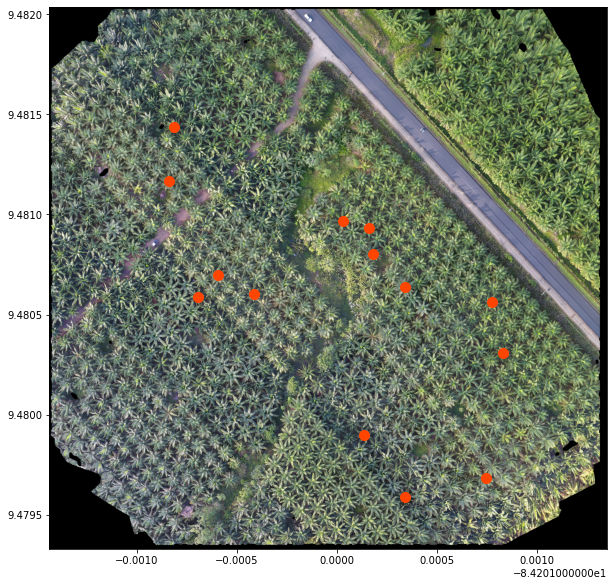

In [3]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(10,10))
#pointData.plot(ax=ax, color='orangered', markersize=100)
for point in pointData:
    ax.scatter(point['geometry']['coordinates'][0],point['geometry']['coordinates'][1], c='orangered', s=100)
show(palmRaster, ax=ax)
plt.show()

In [4]:
#selected band: green
greenBand = palmRaster.read(2)

In [5]:
#extract point value from raster
surveyRowCol = []
for index, values in enumerate(pointData):
    x = values['geometry']['coordinates'][0]
    y = values['geometry']['coordinates'][1]
    row, col = palmRaster.index(x,y)
    print("Point N°:%d corresponds to row, col: %d, %d"%(index,row,col))
    surveyRowCol.append([row,col])

Point N°:0 corresponds to row, col: 848, 1162
Point N°:1 corresponds to row, col: 875, 1263
Point N°:2 corresponds to row, col: 689, 471
Point N°:3 corresponds to row, col: 1693, 1246
Point N°:4 corresponds to row, col: 1940, 1408
Point N°:5 corresponds to row, col: 1864, 1727
Point N°:6 corresponds to row, col: 1368, 1796
Point N°:7 corresponds to row, col: 1168, 1748
Point N°:8 corresponds to row, col: 979, 1279
Point N°:9 corresponds to row, col: 1108, 1407
Point N°:10 corresponds to row, col: 1147, 586
Point N°:11 corresponds to row, col: 473, 494
Point N°:12 corresponds to row, col: 1062, 667
Point N°:13 corresponds to row, col: 1136, 808


In [6]:
# number of template images
print('Number of template images: %d'%len(surveyRowCol))
# define ratio of analysis
radio = 25

Number of template images: 14


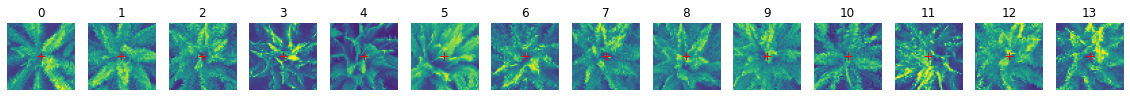

In [7]:
#show all the points of interest, please be careful to have a complete image, otherwise the model wont run
fig, ax = plt.subplots(1, len(surveyRowCol),figsize=(20,5))

for index, item in enumerate(surveyRowCol):
    row = item[0]
    col = item[1]
    ax[index].imshow(greenBand)
    ax[index].plot(col,row,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[index].set_xlim(col-radio,col+radio)
    ax[index].set_ylim(row-radio,row+radio)
    ax[index].axis('off')
    ax[index].set_title(index)


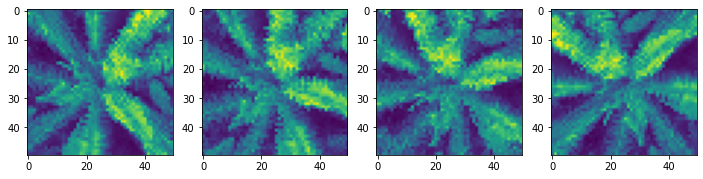

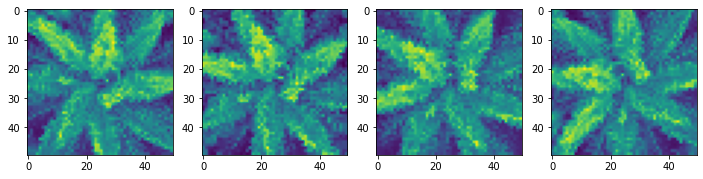

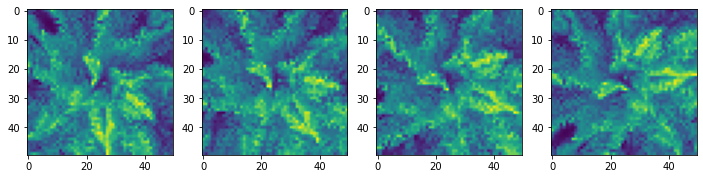

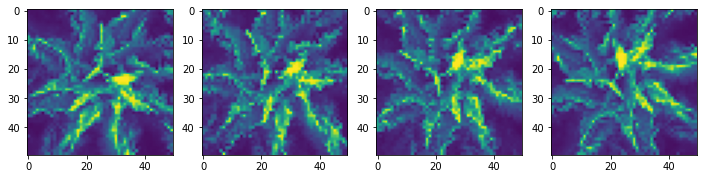

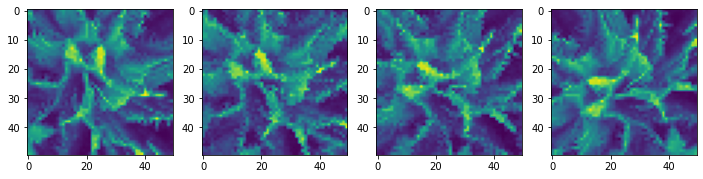

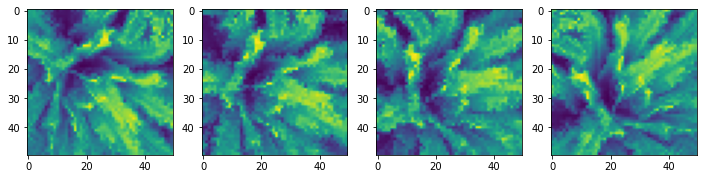

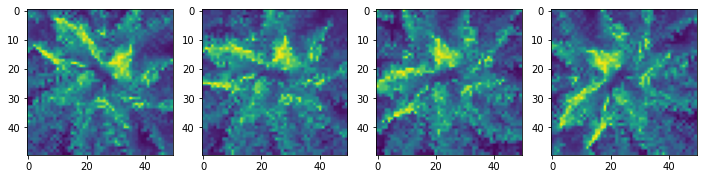

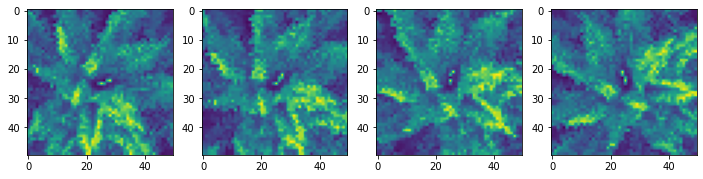

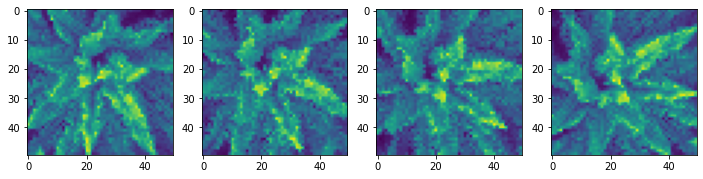

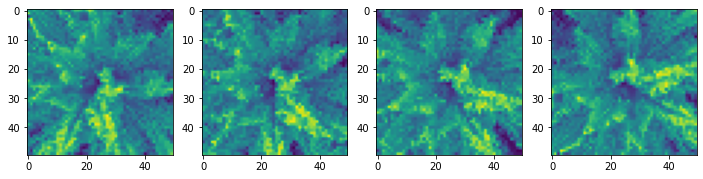

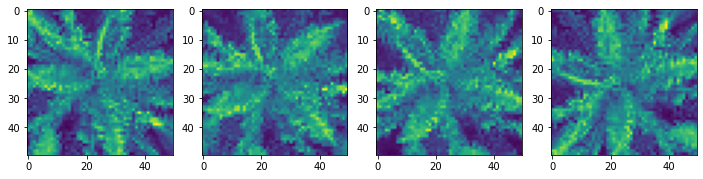

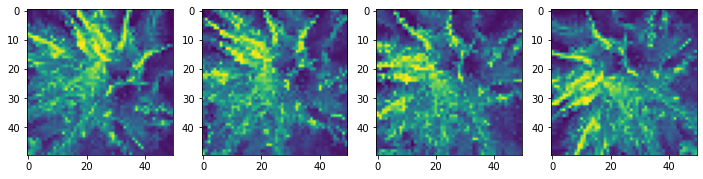

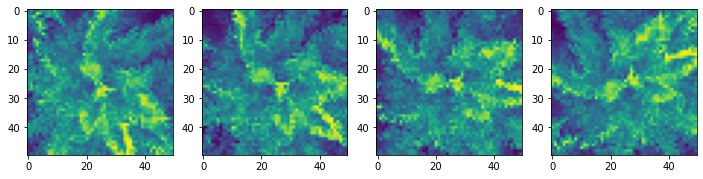

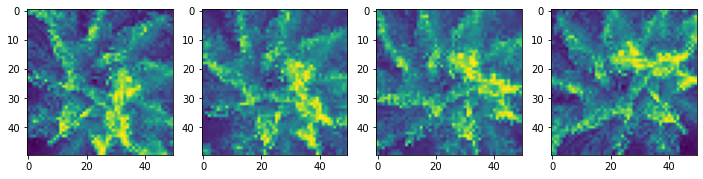

In [8]:
# Match the image to the template

listaresultados = []

templateBandList = []
for rowCol in surveyRowCol:
    imageList = []
    row = rowCol[0]
    col = rowCol[1]
    #append original band
    imageList.append(greenBand[row-radio:row+radio, col-radio:col+radio])
    #append rotated images
    templateBandToRotate = greenBand[row-2*radio:row+2*radio, col-2*radio:col+2*radio]
    rotationList = [i*30 for i in range(1,4)]
    for rotation in rotationList:
        rotatedRaw = Image.fromarray(templateBandToRotate)
        rotatedImage = rotatedRaw.rotate(rotation)
        imageList.append(np.asarray(rotatedImage)[radio:-radio,radio:-radio])
    #plot original and rotated images
    fig, ax = plt.subplots(1, len(imageList),figsize=(12,12))
    for index, item in enumerate(imageList):
        ax[index].imshow(imageList[index])
    #add images to total list
    templateBandList+=imageList

In [9]:
# match the template image to the orthophoto
matchXYList = []
for index, templateband in enumerate(templateBandList):
    if index%10 == 0:
        print('Match template ongoing for figure Nº %d'%index)
    matchTemplate = match_template(greenBand, templateband, pad_input=True)
    matchTemplateFiltered = np.where(matchTemplate>np.quantile(matchTemplate,0.9996))
    for item in zip(matchTemplateFiltered[0],matchTemplateFiltered[1]):
        x, y = palmRaster.xy(item[0], item[1])
        matchXYList.append([x,y])

Match template ongoing for figure Nº 0
Match template ongoing for figure Nº 10
Match template ongoing for figure Nº 20
Match template ongoing for figure Nº 30
Match template ongoing for figure Nº 40
Match template ongoing for figure Nº 50


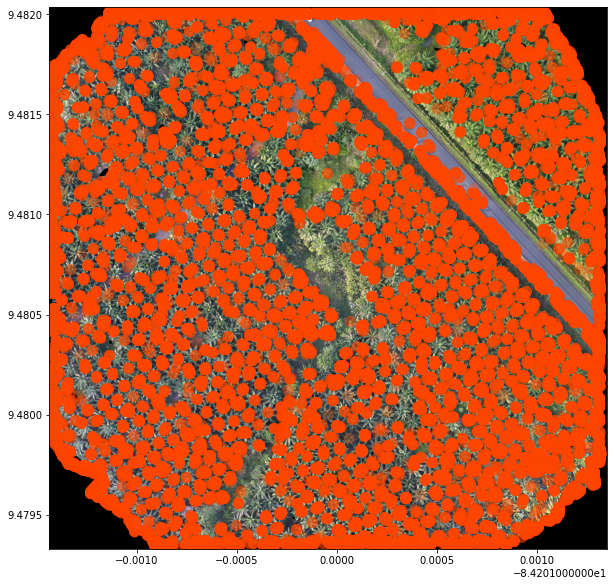

In [10]:
# plot interpreted points over the image
fig, ax = plt.subplots(figsize=(10, 10))
matchXYArray = np.array(matchXYList)
ax.scatter(matchXYArray[:,0],matchXYArray[:,1], marker='o',c='orangered', s=100, alpha=0.25)
show(palmRaster, ax=ax)
plt.show()

In [11]:
# cluster analysis
from sklearn.cluster import Birch
brc = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
brc.fit(matchXYArray)
birchPoint = brc.subcluster_centers_
birchPoint

array([[-84.20038278,   9.48201204],
       [-84.20064248,   9.48201099],
       [-84.20022459,   9.48195993],
       ...,
       [-84.20154469,   9.4803915 ],
       [-84.20115389,   9.47998263],
       [-84.20024387,   9.47971317]])

C:\Users\saulm\anaconda3\envs\geohatarilabs\lib\site-packages\rasterio\plot.py:107: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


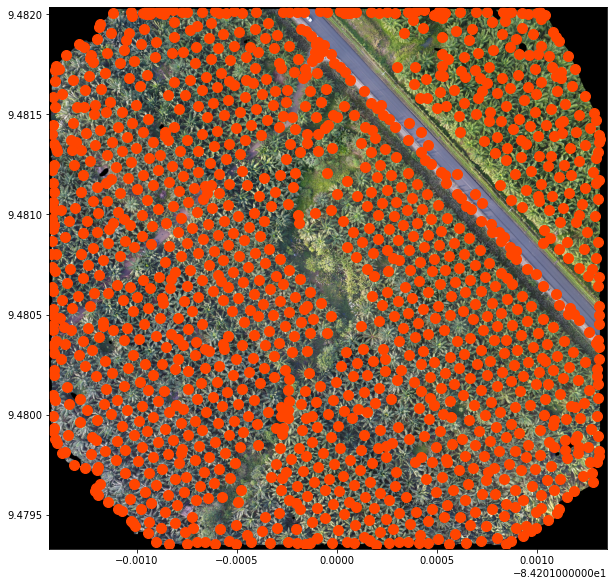

In [12]:
# plot clustered points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=100)
show(palmRaster, ax=ax)
plt.show()

In [14]:
# save xy to a csv file
np.savetxt("../Out/birchPoints.csv", birchPoint, delimiter=",")